### Tối ưu hàm số
Đầu vào:
- Hàm: $f(x, y) = \frac{x^4}{10} - \frac{2x^3}{15} - \frac{2x^2}{5}+y^2+\frac{32}{30}$
- $(x,y) \in {[lower, upper]}^2 $

Đầu ra: 
- Một lời giải $(x_i, y_i)$
- Giá trị nhỏ nhất $f_{min}(x,y)$

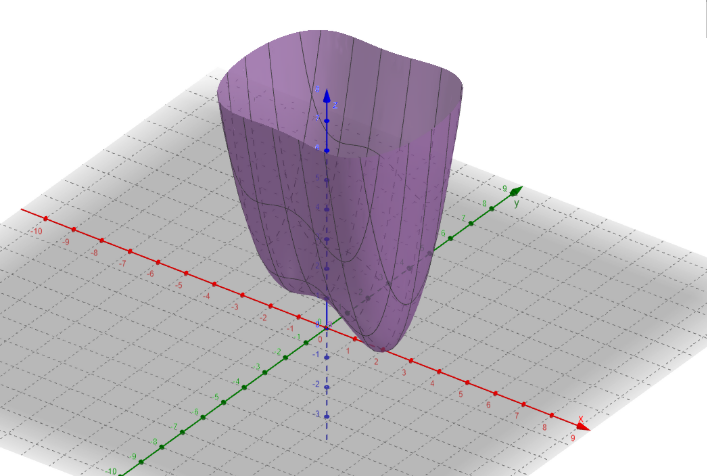

In [1]:
import numpy as np # type: ignore
import random
import copy
import matplotlib.pyplot as plt # type: ignore

In [2]:
class Problem:
    def __init__(self, D, LB, UB):
        self.D = D
        self.LB = LB
        self.UB = UB

In [3]:
def decode(position, problem: Problem):
    x = position * (problem.UB - problem.LB) + problem.LB
    x = np.clip(x, problem.LB, problem.UB)
    return x

def get_fitness(x):
    fx = x[0]**4/10 - 2*x[0]**3/15 - 2*x[0]**2/5 + x[-1]**2 + 32/30
    return -fx

In [4]:
class Individual:
    def __init__(self):
        self.chromosome = None
        self.fitness = None

    def genIndi(self, problem : Problem):
        self.chromosome = np.random.uniform(0.0, 1.0, problem.D)
    
    def cal_fitness(self, problem):
        sol = decode(self.chromosome, problem)
        self.fitness = get_fitness(sol)

    def clone(self):
        return copy.deepcopy(self)
    
    def __repr__(self):
        return f"chromosome={self.chromosome}, fitness={self.fitness:.2f})"

In [5]:
# Simulated binary crossover - SBX
def crossover(parent1, parent2, problem : Problem, eta = 2.0):
    off1 = Individual()
    off2 = Individual()
    r = np.random.rand()
    if (r <= 0.5):
        beta = (2*r)**(1.0/(eta + 1))
    else:
        beta = (1.0/(2*(1 - r)))**(1.0/(eta + 1))
    p1 = parent1.chromosome
    p2 = parent2.chromosome
    c1 = 0.5 * ((1 + beta) * p1 + (1 - beta) * p2)
    c2 = 0.5 * ((1 - beta) * p1 + (1 + beta) * p2)
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    off1.chromosome = c1
    off2.chromosome = c2
    return off1.clone(), off2.clone()


In [6]:

# Polynomial mutaion - PM
def mutation(indi : Individual, eta = 20.0):
    chr = indi.chromosome
    for i in range(chr.size):
        mu = np.random.rand()
        if (mu <= 0.5):
            delta = (2 * mu)**(1.0/(1 + eta)) - 1
            chr[i] = chr[i] + delta * chr[i]
        else:
            delta = 1 - (2 - 2*mu)**(1.0/(1 + eta))
            chr[i] = chr[i] + delta * (1 - chr[i])
            
    chr = np.clip(chr, 0.0, 1.0)
    indi.chromosome = chr
    return indi.clone()

In [7]:
class Population:
    def __init__(self, pop_size, problem : Problem):
        self.pop_size = pop_size
        self.list_indi = []
        self.problem = problem
    
    def genPop(self):
        for i in range(self.pop_size):
            indi = Individual()
            indi.genIndi(self.problem)
            indi.cal_fitness(self.problem)
            self.list_indi.append(indi)

    def show(self):
        for i in range(len(self.list_indi)):
            print(f"Individual {i}: {self.list_indi[i]}")


In [8]:
def selection(list, k = 2):
    tour1 = random.sample(list, k)
    tour2 = random.sample(list, k)
    x = max(tour1, key=lambda indi: indi.fitness)
    y = max(tour2, key=lambda indi: indi.fitness)
    return x.clone(), y.clone() 

In [9]:
def survival_selection(list, pop_size):
    list = sorted(list, key=lambda indi: indi.fitness, reverse=True)
    list = list[0: pop_size]
    return list

In [10]:
D = 2
LB = -50
UB = 50
problem = Problem(D, LB, UB)

pop  = Population(5, problem)
pop.genPop()
pop.show()

p1, p2 = selection(pop.list_indi, 2)
print(f"p1: {decode(p1.chromosome, problem)}, fitness={p1.fitness:.2f}")
print(f"p2: {decode(p2.chromosome, problem)}, fitness={p2.fitness:.2f}")

p1 = mutation(p1)
p2 = mutation(p2) 

print(f"p1: {decode(p1.chromosome, problem)}, fitness={p1.fitness:.2f}")
print(f"p2: {decode(p2.chromosome, problem)}, fitness={p2.fitness:.2f}")


Individual 0: chromosome=[0.24775552 0.0805298 ], fitness=-44130.37)
Individual 1: chromosome=[0.0964041 0.0231514], fitness=-275719.28)
Individual 2: chromosome=[0.17648913 0.65917926], fitness=-113885.92)
Individual 3: chromosome=[0.32799371 0.85126131], fitness=-10548.51)
Individual 4: chromosome=[0.56687757 0.74507355], fitness=-743.95)
p1: [ 6.6877572  24.50735521], fitness=-743.95
p2: [-17.20062903  35.12613142], fitness=-10548.51
p1: [ 6.43660523 23.06981901], fitness=-743.95
p2: [-16.87409822  35.80641913], fitness=-10548.51


In [11]:
def GA(problem, pop_size, max_gen, p_c, p_m):
    pop = Population(pop_size, problem)
    pop.genPop()
    history = []
    for i in range(max_gen):
        child = []
        while (len(child) < pop_size):
            p1, p2 = selection(pop.list_indi)
            if np.random.rand() <= p_c:
                c1, c2 = crossover(p1, p2, problem)
                c1.cal_fitness(problem)
                c2.cal_fitness(problem)
                child.append(c1)
                child.append(c2)
            if np.random.rand() <= p_m:
                p1 = mutation(p1)
                p2 = mutation(p2)
                p1.cal_fitness(problem)
                p2.cal_fitness(problem)
                child.append(p1)
                child.append(p2)
        pop.list_indi = survival_selection(pop.list_indi + child, pop_size)
        history.append(pop.list_indi[0].fitness)
    solution = pop.list_indi[0]
    return history, solution


In [12]:
# setup
D = 2
LB = -50
UB = 50
problem = Problem(D, LB, UB)

pop_size = 5
max_gen = 20
Pc = 0.9
Pm = 1

# start
fitness_history, solution = GA(problem, pop_size, max_gen, Pc, Pm)

#show
for i in range(len(fitness_history)):
    print(f"Generation {i}, best fitness = {fitness_history[i]}")

Generation 0, best fitness = -114.91645773195043
Generation 1, best fitness = -80.29665762908505
Generation 2, best fitness = -44.36365514289954
Generation 3, best fitness = -26.08879472008635
Generation 4, best fitness = -10.471989007942542
Generation 5, best fitness = -2.7310273940070777
Generation 6, best fitness = -1.0960441913065713
Generation 7, best fitness = -1.087439023892525
Generation 8, best fitness = -1.087439023892525
Generation 9, best fitness = -0.7633141711284263
Generation 10, best fitness = -0.7633141711284263
Generation 11, best fitness = -0.7617331923485589
Generation 12, best fitness = -0.42750661234138054
Generation 13, best fitness = -0.09235491182628397
Generation 14, best fitness = -0.09235491182628397
Generation 15, best fitness = -0.09235491182628397
Generation 16, best fitness = -0.09235491182628397
Generation 17, best fitness = -0.09235491182628397
Generation 18, best fitness = -0.09235491182628397
Generation 19, best fitness = -0.09235491182628397


In [13]:
np.set_printoptions(precision=2, suppress=True)
print("solution:")
print(decode(solution.chromosome, problem))
print(f"The Rosenbrock value is: {- solution.fitness:.2f}")

solution:
[ 1.9  -0.28]
The Rosenbrock value is: 0.09


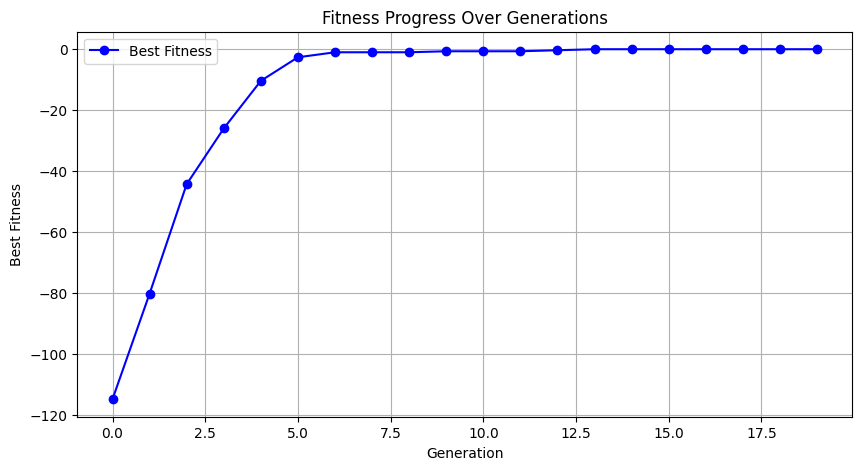

In [14]:
generations = list(range(len(fitness_history)))
plt.figure(figsize=(10, 5))
plt.plot(generations, fitness_history, marker='o', linestyle='-', color='b', label='Best Fitness')

plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Fitness Progress Over Generations")
plt.legend()
plt.grid(True)
plt.show()